In [1]:
import time
import hydroeval as he
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
from datetime import date
from datetime import datetime, timedelta
sys.path.insert(0, './CFE')
import bmi_cfe_originial
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI

sys.path.append('../USGS/USGS_BMI_FT')
import bmi_usgs


In [2]:
print(bmi_cfe_originial)
#print(bmi_cfe_peturb)
print(bmi_cfe_enkf_peturb)
print(Bmi_da_ENKF_forSBMI)
print(bmi_usgs)


<module 'bmi_cfe_originial' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_originial.py'>
<module 'bmi_cfe_enkf_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_enkf_peturb.py'>
<module 'Bmi_da_ENKF_forSBMI' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./Assimilation\\Bmi_da_ENKF_forSBMI.py'>
<module 'bmi_usgs' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\../USGS/USGS_BMI_FT\\bmi_usgs.py'>


In [3]:
## Open BMI's for each file
# cfe_open = bmi_cfe.BMI_CFE()
# cfe_peturbed = bmi_cfe_peturb.BMI_CFE()
# cfe_analysis = bmi_cfe_statevars.BMI_CFE() #true model in the end with updated state vars

cfe_open = bmi_cfe_originial.BMI_CFE()
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars
#cfe_analysis = bmi_cfe_statevars_et.BMI_CFE(

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()
usgs = bmi_usgs.BMI_USGS()

In [4]:
## Initialize the BMI's
#cfe_open.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
#cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
#cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe.json') # I am confused what this config file should look like

# make one bmi for all of this and options in config file

# ## Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')

enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')


# 2016 and 2017
# cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration_16_17.json')
# cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration_16_17.json')
# cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration_16_17.json')

# enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
# usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config_16_17.json')


initialized 84.21526
                         Date     Flow  validity
0   2017-05-15 04:00:00+00:00  166.500       1.0
1   2017-05-15 05:00:00+00:00  161.000       1.0
2   2017-05-15 06:00:00+00:00  156.750       1.0
3   2017-05-15 07:00:00+00:00  151.500       1.0
4   2017-05-15 08:00:00+00:00  148.750       1.0
..                        ...      ...       ...
763 2017-06-15 23:00:00+00:00   28.400       1.0
764 2017-06-16 00:00:00+00:00   28.175       1.0
765 2017-06-16 01:00:00+00:00   28.400       1.0
766 2017-06-16 02:00:00+00:00   27.500       1.0
767 2017-06-16 03:00:00+00:00   27.500       1.0

[768 rows x 3 columns]
USGS station ID 01123000


              time  APCP_surface  RAINRATE      T2D       Q2D     U2D     V2D  \
0     5/15/17 0:00           0.0       0.0  284.078  0.006616  6.0804 -1.9670   
1     5/15/17 1:00           0.0       0.0  283.180  0.006650  6.0304 -2.0740   
2     5/15/17 2:00           0.0       0.0  282.440  0.006614  5.9856 -2.1828   
3     5/15/17 3:00           0.0       0.0  281.662  0.006476  5.9402 -2.2888   
4     5/15/17 4:00           0.0       0.0  281.702  0.006530  6.3688 -2.5458   
..             ...           ...       ...      ...       ...     ...     ...   
763  6/15/17 19:00           0.0       0.0  295.270  0.007334 -1.1600  4.5018   
764  6/15/17 20:00           0.0       0.0  294.610  0.006788 -1.2230  4.4990   
765  6/15/17 21:00           0.0       0.0  293.624  0.006776 -1.2812  4.4996   
766  6/15/17 22:00           0.0       0.0  292.722  0.006714 -1.5682  3.8524   
767  6/15/17 23:00           0.0       0.0  291.554  0.006650 -1.8486  3.1996   

          PSFC   SWDOWN   L

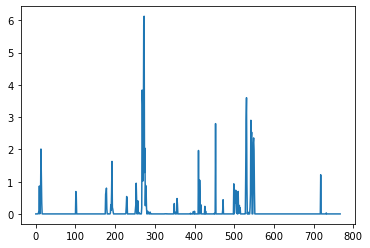

In [5]:
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)
plt.plot(df_forcing['APCP_surface'])

values = df_forcing['APCP_surface']
print(values)

In [6]:
#Originial Version 
# basian coupling numerical error:
# the distrbutions are not well calibrated
# valibrate the model
# calibrate the pert
# set b matrix right: cov matrix in the peterbations.
# 2x2 matrix
# ground_water_storage_m 
# ground_water_storage_m <



#Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
cfeAnalysis = []
cfeEnKF = []
cfe_def = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE

    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip +1) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip +1)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip +1)
    
    # Update usgs data and get value to put into EnKF
    usgs.update()
    obs = np.array(usgs.get_value('Flow')) #need array for EnKf function. should get this when initialize. CFS 
    #obs_m = (obs * 3.281**3) #converting cfs to m3/s
    #print(obs_m)
    validity=usgs.get_value('validity')[i]
    print("-------------------------------------------------")
    print("validity",validity)

    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()
    
    # Get state variables originial values from CFE Analysis to update in enkf
    # Get state vars from Peturbed. These are values as enkf uses
    soil_storage_avail = cfe_peturbed.get_value('soil_storage_avail_m')
    soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
    cfe_def.append(soil_reservoir_storage_deficit)
    storage_max_m= cfe_peturbed.get_value("storage_max_out_m")
    print(storage_max_m)
    
    print("DEF!!",cfe_peturbed.get_value("soil_reservoir_storage_deficit_out_m"))
    surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')
    # if surface_runoff>0:
    #     print("surface_runoff",surface_runoff)
    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_depth') #m3/s
    cfeOpen.append(outflow) #for plotting
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    #print("mean", outflow_peturb_mean)
    #print("covar", outflow_peturb_covar)
    cfePeturbed.append(outflow_peturb_mean) #for plotting
    # print(usgs.get_value('validity')[0])


    # Set EnKF value to usgs, mean, and covariance. Get value from it then
    enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
    enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf   
    enkf.set_value('storage_max_m',storage_max_m)
    print("enkf.set_value('storage_max_m',storage_max_m)")
    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([obs[i]]))
    enkf_validity=enkf.set_value('validity',validity)
    enkf.update()


    #For plotting############################# after this
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)

    state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
    state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_updated_m')
    # state_transition_runoff       = enkf.get_value('surface_runoff_depth_updated_m')
    state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')
    # print("Updated deficit",state_transition_soil_res)


#     # Set value for CFE analysis based on the state variable change from the EnKF factor tog et true streamflow
    cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage) #look up value from lookup table based on EnKF factor   
    cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res) #look up value from lookup table based on EnKF factor   
    # cfe_analysis.set_value('DIRECT_RUNOFF', state_transition_runoff) 
    cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)

    cfe_analysis.update() #get new streamflow value based on state var change
    # set them in to pert
    outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
    cfeAnalysis.append(outflow_analysis) #for plotting
        
     # Update final model from value of analysis
    cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
    cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
    print("should be Updated deficit",cfe_updated_everything_soil_res)
    cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')

    cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
    cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
    cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)
    # cfe_peturbed.update()
 
# # Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
usgs.finalize()
enkf.finalize()

-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.33997484961299995
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.33997484961299995
EnKF Code predicted, X Post [166.63497103]
***********under estimaiton ratio [22.91031827]
Observation BMI [166.5]
CFE [7.27335906]
enkf [166.63497103]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.13763417700537006
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.13763417700537006
EnKF Code predicted, X Post [161.2639824]
***********under estimaiton ratio [1.05584928]
Observation BMI [161.]
CFE [152.73390342]
enkf [161.2639824]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.05327258587887107
enkf.set_value('storage_

EnKF Code predicted, X Post [77.79651756]
***********under estimaiton ratio [2.7016313]
Observation BMI [78.1]
CFE [28.79612685]
enkf [77.79651756]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.021019694576741688
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [77.53730531]
***********under estimaiton ratio [1.29032928]
Observation BMI [77.2]
CFE [60.09109966]
enkf [77.53730531]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.021019694576741688
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [76.85550784]
***********under estimaiton ratio [1.505183]
Observation BMI [76.65]
CFE [51.06057395]
enkf

EnKF Code predicted, X Post [46.84497693]
***********under estimaiton ratio [1.15056599]
Observation BMI [46.9]
CFE [40.71472429]
enkf [46.84497693]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.021019694576741688
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [46.96887779]
***********under estimaiton ratio [1.94700303]
Observation BMI [46.6]
CFE [24.12367992]
enkf [46.96887779]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.021019694576741688
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [46.627248]
***********under estimaiton ratio [1.24461475]
Observation BMI [46.6]
CFE [37.46319724]
enkf

***********under estimaiton ratio [1.16913278]
Observation BMI [44.]
CFE [37.51783879]
enkf [43.8633351]
should be Updated deficit [0.01416348]
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.020827226548922884
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.020827226548922884
EnKF Code predicted, X Post [44.45168046]
***********under estimaiton ratio [1.10846317]
Observation BMI [44.3]
CFE [40.10208149]
enkf [44.45168046]
should be Updated deficit [0.01416348]
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.020933639188214448
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.020933639188214448
EnKF Code predicted, X Post [44.79253275]
***********under estimaiton ratio [1.05538711]
Observation BMI [44.9]
CFE [42.44180375]
enkf [44.79253275]
shoul

enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021008349623881095
EnKF Code predicted, X Post [42.40853755]
***********under estimaiton ratio [1.14604023]
Observation BMI [42.35]
CFE [37.00440579]
enkf [42.40853755]
should be Updated deficit [0.01289444]
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.021010766300066375
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021010766300066375
EnKF Code predicted, X Post [43.11685063]
***********under estimaiton ratio [1.25254889]
Observation BMI [42.9]
CFE [34.42328766]
enkf [43.11685063]
should be Updated deficit [0.01289444]
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.021017799533367354
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage

EnKF Code predicted, X Post [79.98082048]
***********under estimaiton ratio [2.45361372]
Observation BMI [80.1]
CFE [32.59715246]
enkf [79.98082048]
should be Updated deficit 0.021019694576741688
-------------------------------------------------
validity 0.0
1.0209454943333334
DEF!! 0.021019694576741688
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [nan]
 warning validity is zero
should be Updated deficit 0.021019694576741688
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.021019694576741688
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [78.30046512]
***********under estimaiton ratio [2.04957497]
Observation BMI [78.3]
CFE [38.2032696]
enkf [78.30046512]
should be Updated deficit 0.0210196

C:\Users\zjbut\Documents\GitHub\NextGen---The-Simulators-\Toy_Model\./Assimilation\EnKF.py:69: RuntimeWarning: invalid value encountered in floor_divide
  e.factor=e.res//e.x


 0.021018721204664303
-------------------------------------------------
validity 0.0
1.0209454943333334
DEF!! 0.021018470873147455
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021018470873147455
EnKF Code predicted, X Post [nan]
 warning validity is zero
should be Updated deficit 0.021018470873147455
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.021018461577053227
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021018461577053227
EnKF Code predicted, X Post [75.76256437]
***********under estimaiton ratio [2.33164524]
Observation BMI [75.5]
CFE [32.49317822]
enkf [75.76256437]
should be Updated deficit 0.021018470873147455
-------------------------------------------------
validity 0.0
1.0209454943333334
DEF!! 0.02101943286454
enkf.set_value('storage_max_m',storage_max_m)
Beginning-

EnKF Code predicted, X Post [nan]
 warning validity is zero
should be Updated deficit 0.021019689991627954
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.021019693603518186
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019693603518186
EnKF Code predicted, X Post [52.74845754]
***********under estimaiton ratio [1.87293575]
Observation BMI [52.6]
CFE [28.16351689]
enkf [52.74845754]
should be Updated deficit 0.021019689991627954
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.021001197230143487
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021001197230143487
EnKF Code predicted, X Post [52.60979421]
***********under estimaiton ratio [1.62917358]
Observation BMI [52.6]
CFE [32.29231979]
enkf [52.60979421]
should be Updated deficit 0.021019

enkf [48.69825399]
should be Updated deficit [0.00849681]
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.021019693738226097
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019693738226097
EnKF Code predicted, X Post [47.53787363]
***********under estimaiton ratio [1.73129482]
Observation BMI [47.5]
CFE [27.45798875]
enkf [47.53787363]
should be Updated deficit [0.00849681]
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.021019694398760613
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694398760613
EnKF Code predicted, X Post [46.83440664]
***********under estimaiton ratio [1.67807976]
Observation BMI [46.6]
CFE [27.9095236]
enkf [46.83440664]
should be Updated deficit [0.00849681]
-------------------------------------------------
val

EnKF Code predicted, X Post [73.24369863]
***********under estimaiton ratio [1.24243824]
Observation BMI [73.4]
CFE [58.95158107]
enkf [73.24369863]
should be Updated deficit [0.01931436]
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.020869569012911482
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.020869569012911482
EnKF Code predicted, X Post [78.57858448]
***********under estimaiton ratio [1.08653987]
Observation BMI [78.7]
CFE [72.32001919]
enkf [78.57858448]
should be Updated deficit [0.01931436]
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02078669964083102
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02078669964083102
EnKF Code predicted, X Post [83.63835139]
surface_runoff_ratio [63.91249717]
Leftover vol 0.0
surface _runoff [6

EnKF Code predicted, X Post [78.9288655]
***********under estimaiton ratio [1.36563321]
Observation BMI [79.]
CFE [57.79653335]
enkf [78.9288655]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.021019694576741688
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [77.52873783]
***********under estimaiton ratio [2.0952373]
Observation BMI [77.5]
CFE [37.00236626]
enkf [77.52873783]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.021019694576741688
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [76.616861]
***********under estimaiton ratio [1.7418745]
Observation BMI [76.65]
CFE [43.98529344]
enkf [76

EnKF Code predicted, X Post [43.79773063]
surface_runoff_ratio [26.19281628]
Leftover vol 0.0
surface _runoff [26.19281628]
***********over estimaiton ratio [1.]
Observation BMI [44.]
CFE [50.7987859]
enkf [43.79773063]
should be Updated deficit [0.0104589]
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.021019694576741688
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [43.93005078]
***********under estimaiton ratio [1.73445875]
Observation BMI [44.]
CFE [25.32781522]
enkf [43.93005078]
should be Updated deficit [0.0104589]
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.021019694576741688
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [44.22620805]


EnKF Code predicted, X Post [29.91211099]
***********under estimaiton ratio [1.73079447]
Observation BMI [29.8]
CFE [17.28230097]
enkf [29.91211099]
should be Updated deficit [0.01922917]
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.021019694576741688
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [29.13635656]
***********under estimaiton ratio [1.05859851]
Observation BMI [29.2]
CFE [27.52351942]
enkf [29.13635656]
should be Updated deficit [0.01922917]
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.021019694576741688
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.021019694576741688
EnKF Code predicted, X Post [35.21881778]
surface_runoff_ratio [20.3706415]
Leftover vol 0.0
surface _runoff [

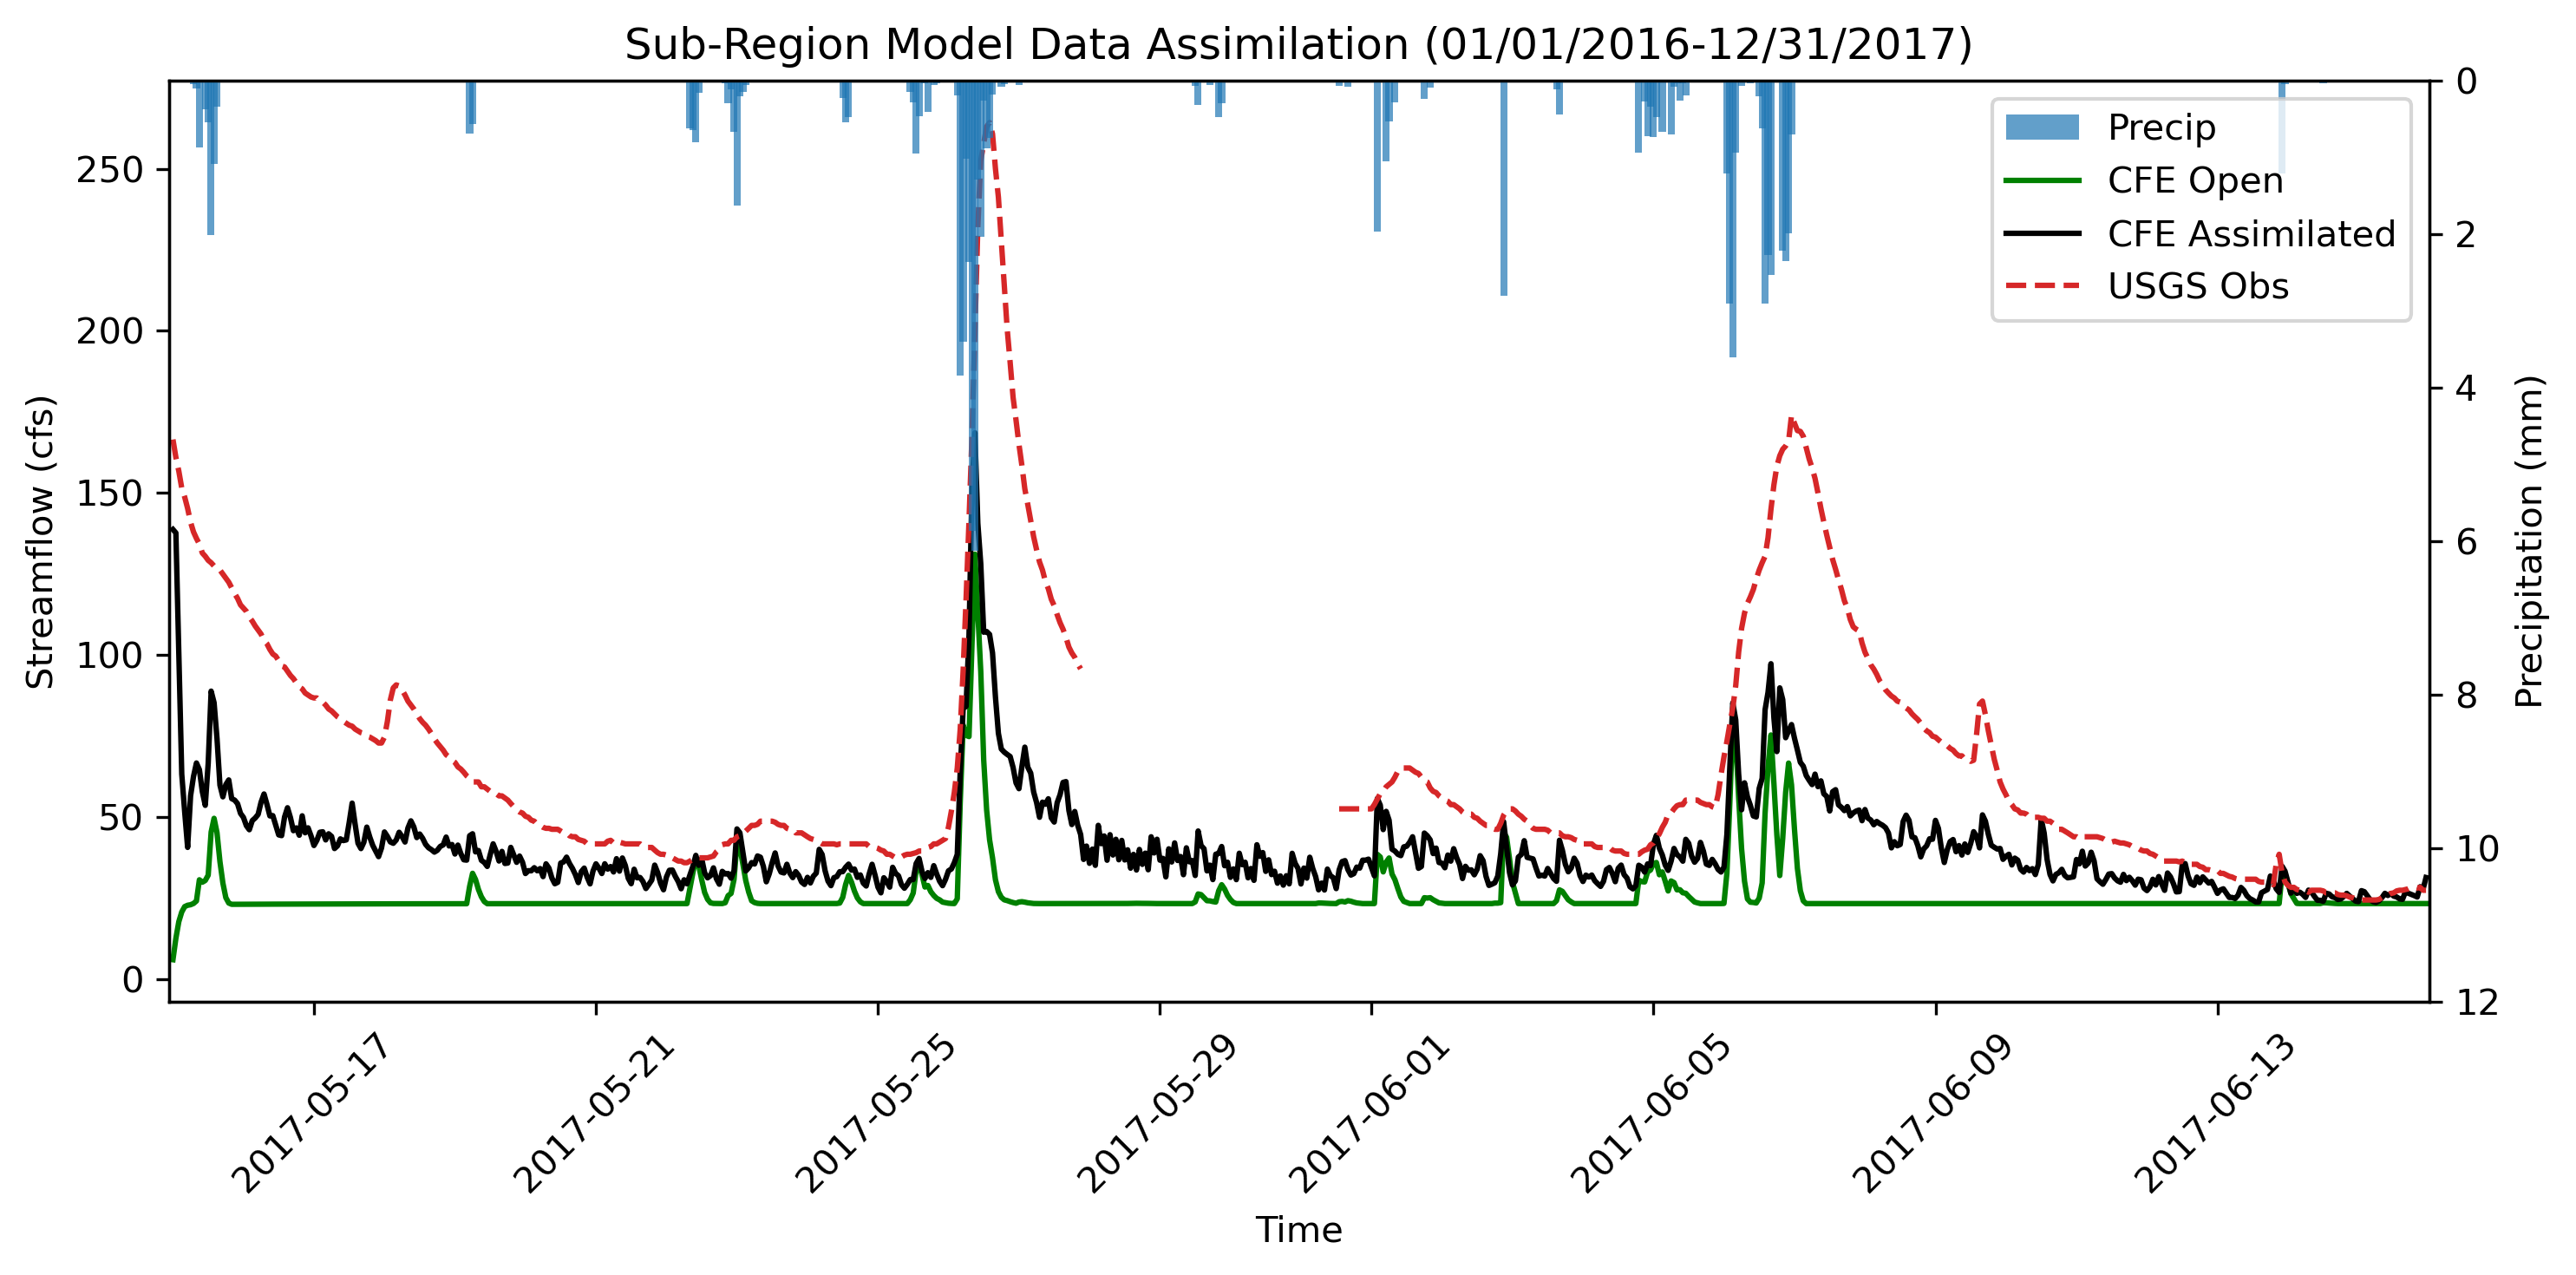

In [7]:
istart_plot=0
iend_plot=17520
x = list(range(istart_plot, iend_plot))

# Get Date out of forcing file for plotting
Date_list = []
df_forcing['time'] = pd.to_datetime(df_forcing['time'], infer_datetime_format=True) 

fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

ax2 = ax1.twinx()

ax1.set_xlabel('Time')
ax1.set_ylabel('Streamflow (cfs)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,12,1)
ax2.invert_yaxis()


#plt.title('Sub-Region Model Data Assimilation (5/15/2017-6/15/2017)')
plt.title('Sub-Region Model Data Assimilation (01/01/2016-12/31/2017)')
Precip = ax2.bar(df_forcing['time'], df_forcing['APCP_surface'],width=0.1,alpha=0.7, color="tab:blue", label = 'Precip')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
Open, = ax1.plot(df_forcing['time'], cfeOpen, color = 'green', label = 'CFE Open')
Analysis, = ax1.plot(df_forcing['time'], cfeAnalysis, color = 'black', label = 'CFE Assimilated')
Obs, = ax1.plot(df_forcing['time'], obs, color = 'tab:red', linestyle='dashed', label = 'USGS Obs')
#ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')

#ax1.set_xlim([date(2017, 5, 15), date(2017, 6, 15)]) ## Customize date range for all plots
ax1.tick_params(axis='x', labelrotation = 45)

plt.legend(handles = [Precip,Open,Analysis,Obs], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))

plt.savefig("SubRegionModel.png")
fig.tight_layout()
ax1.margins(x=0)

plt.show()


In [8]:
len(cfeOpen)

768

In [9]:
len(cfeAnalysis)

768

In [10]:
len(obs)

768

In [11]:
df=pd.DataFrame({"obs":obs,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})

In [12]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [13]:
# nse_open=he.evaluator(he.nse,np.array(obs),np.array(cfeOpen))
# nse_analysis=he.evaluator(he.nse,obs[istart_plot:iend_plot],cfeAnalysis[istart_plot:iend_plot])
# kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, obs,cfeOpen)
# print(r_open[0])

In [14]:
# CFE open eval
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias_open=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("r_open=",r_open[0])
print("KGE_open=",kge_open[0])
print("NSE_open=", nse_open[0])
print("PBIAS_open=", pbias_open[0])

r_open= 0.3942471460267489
KGE_open= -2.593655846185467
NSE_open= -31.95498758094964
PBIAS_open= -157.16828669631977


In [15]:
# CFE Analysis
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("r_analysis=",r_analysis[0])
print("KGE_analysis=",kge_analysis[0])
print("NSE_analysis=", nse_analysis[0])
print("PBIAS_analysis=", pbias_analysis[0])

r_analysis= 0.8644657723975064
KGE_analysis= -0.6058474592794529
NSE_analysis= -4.3385593410732035
PBIAS_analysis= -63.31653211910979


In [16]:
print("mean_obs=",np.mean(df["obs"]))
print("STD_obs=",np.std(df["obs"]))
print("mean_open=",np.mean(df["cfeOpen"]))
print("STD_open=",np.std(df["cfeOpen"]))
print("mean_analysis=",np.mean(df["cfeAnalysis"]))
print("STD_analysis=",np.std(df["cfeAnalysis"]))


mean_obs= 66.93546270718221
STD_obs= 40.45261101684418
mean_open= 26.027883751554423
STD_open= 9.690485992488075
mean_analysis= 40.985111451157344
STD_analysis= 16.380783032859956
